In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.13.0
GPU: []


In [3]:
BASE_DIR = "../data"
IMAGE_DIR = os.path.join(BASE_DIR, "images")
CSV_PATH = os.path.join(BASE_DIR, "HAM10000_metadata.csv")

IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 30
NUM_CLASSES = 7


In [4]:
df = pd.read_csv(CSV_PATH)

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['label'] = df['dx'].map(lesion_type_dict)
df['label_idx'] = pd.Categorical(df['label']).codes
df['path'] = df['image_id'].apply(lambda x: os.path.join(IMAGE_DIR, x + ".jpg"))

df['age'].fillna(df['age'].mean(), inplace=True)

df.head()


C:\Users\khete\AppData\Local\Temp\ipykernel_17052\1447778043.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].mean(), inplace=True)


,lesion_id,image_id,dx,dx_type,age,sex,localization,label,label_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,../data\images\ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,../data\images\ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,../data\images\ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,../data\images\ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,../data\images\ISIC_0031633.jpg


In [5]:
def load_image(path):
    img = Image.open(path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    return np.asarray(img)

df['image'] = df['path'].apply(load_image)

X = np.stack(df['image'].values)
y = df['label_idx'].values

print("Images shape:", X.shape)
print("Labels shape:", y.shape)


Images shape: (10015, 224, 224, 3)
Labels shape: (10015,)


In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (8012, 224, 224, 3)
Val: (1001, 224, 224, 3)
Test: (1002, 224, 224, 3)


In [7]:
X_train = preprocess_input(X_train)
X_val   = preprocess_input(X_val)
X_test  = preprocess_input(X_test)

y_train_cat = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val_cat   = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)
y_test_cat  = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)


In [8]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
class_weights


{0: 4.368593238822246,
 1: 2.7848453249913105,
 2: 1.3021290427433772,
 3: 12.440993788819876,
 4: 0.21338020666879728,
 5: 1.2860353130016051,
 6: 10.040100250626567}

In [9]:
datagen = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)


In [10]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [11]:
callbacks = [
    EarlyStopping(patience=6, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3, min_lr=1e-6)
]


In [13]:
history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
1002/1002 [==============================] - 445s 443ms/step - loss: 1.6923 - accuracy: 0.4046 - val_loss: 1.4162 - val_accuracy: 0.4705 - lr: 1.0000e-04
Epoch 2/30
1002/1002 [==============================] - 673s 671ms/step - loss: 1.4237 - accuracy: 0.4843 - val_loss: 1.2840 - val_accuracy: 0.5345 - lr: 1.0000e-04
Epoch 3/30
1002/1002 [==============================] - 638s 637ms/step - loss: 1.3099 - accuracy: 0.5142 - val_loss: 1.1993 - val_accuracy: 0.5584 - lr: 1.0000e-04
Epoch 4/30
1002/1002 [==============================] - 667s 666ms/step - loss: 1.2280 - accuracy: 0.5242 - val_loss: 1.3331 - val_accuracy: 0.4855 - lr: 1.0000e-04
Epoch 5/30
1002/1002 [==============================] - 571s 570ms/step - loss: 1.2010 - accuracy: 0.5389 - val_loss: 1.0412 - val_accuracy: 0.6204 - lr: 1.0000e-04
Epoch 6/30
1002/1002 [==============================] - 646s 645ms/step - loss: 1.1362 - accuracy: 0.5619 - val_loss: 1.2099 - val_accuracy: 0.5155 - lr: 1.0000e-04
Epoch 7/30

In [14]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val_cat),
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
1002/1002 [==============================] - 291s 282ms/step - loss: 1.3267 - accuracy: 0.4299 - val_loss: 1.3378 - val_accuracy: 0.4945 - lr: 1.0000e-05
Epoch 2/15
1002/1002 [==============================] - 646s 645ms/step - loss: 1.2018 - accuracy: 0.4873 - val_loss: 1.1942 - val_accuracy: 0.5584 - lr: 1.0000e-05
Epoch 3/15
1002/1002 [==============================] - 716s 714ms/step - loss: 1.1369 - accuracy: 0.5286 - val_loss: 1.1430 - val_accuracy: 0.5814 - lr: 1.0000e-05
Epoch 4/15
1002/1002 [==============================] - 534s 533ms/step - loss: 1.0647 - accuracy: 0.5555 - val_loss: 1.1103 - val_accuracy: 0.5924 - lr: 1.0000e-05
Epoch 5/15
1002/1002 [==============================] - 586s 585ms/step - loss: 1.0500 - accuracy: 0.5613 - val_loss: 1.0853 - val_accuracy: 0.5924 - lr: 1.0000e-05
Epoch 6/15
1002/1002 [==============================] - 478s 475ms/step - loss: 1.0032 - accuracy: 0.5775 - val_loss: 1.0738 - val_accuracy: 0.6014 - lr: 1.0000e-05
Epoch 7/15

ResourceExhaustedError: Graph execution error:

Detected at node 'model/block2a_expand_bn/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\ipykernel\kernelapp.py", line 758, in start
      self.io_loop.start()
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\tornado\platform\asyncio.py", line 211, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\ipykernel\utils.py", line 71, in preserve_context
      return await f(*args, **kwargs)
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\ipykernel\kernelbase.py", line 614, in shell_main
      await self.dispatch_shell(msg, subshell_id=subshell_id)
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_shell
      await result
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\ipykernel\ipkernel.py", line 366, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\ipykernel\kernelbase.py", line 827, in execute_request
      reply_content = await reply_content
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\ipykernel\ipkernel.py", line 458, in do_execute
      res = shell.run_cell(
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\ipykernel\zmqshell.py", line 663, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell
      result = self._run_cell(
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\IPython\core\interactiveshell.py", line 3132, in _run_cell
      result = runner(coro)
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\IPython\core\interactiveshell.py", line 3336, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\IPython\core\interactiveshell.py", line 3519, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\khete\AppData\Local\Temp\ipykernel_17052\1648755214.py", line 12, in <module>
      history_fine = model.fit(
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\engine\functional.py", line 512, in call
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\layers\normalization\batch_normalization.py", line 597, in call
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\layers\normalization\batch_normalization.py", line 990, in _fused_batch_norm
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\utils\control_flow_util.py", line 108, in smart_cond
    File "c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\layers\normalization\batch_normalization.py", line 979, in _fused_batch_norm_inference
Node: 'model/block2a_expand_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[8,112,112,96] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model/block2a_expand_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_146716]

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=1)
print("Test Accuracy:", test_acc)


32/32 [==============================] - 22s 670ms/step - loss: 0.8518 - accuracy: 0.6786
Test Accuracy: 0.6786426901817322


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x0000022290F8CC10>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x0000022290F8CC10>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Orig

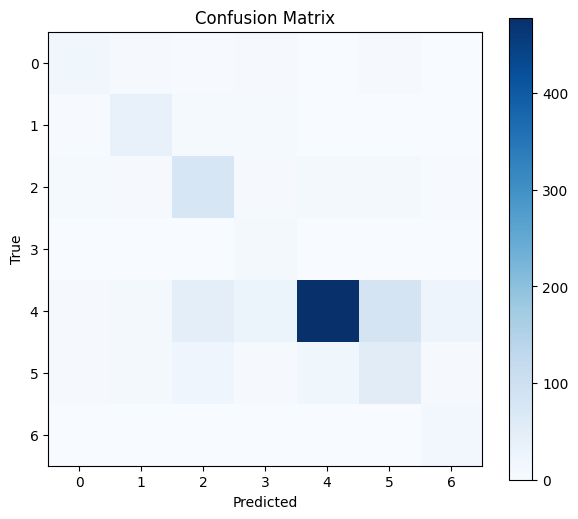

In [16]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred, target_names=lesion_type_dict.values()))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
os.makedirs("../models", exist_ok=True)
model.save("../models/skin_efficientnet_01.h5")
print("Model saved successfully")


c:\Users\khete\anaconda3\envs\skin_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


Model saved successfully
